# Short Term Risk Prediction With XGBoost

In this notebook we try and predict readmission in less than 30 days using data created in the Feature Engineering notebook.

In [187]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import scikitplot as skplt
import time

os.environ["OMP_NUM_THREADS"] = "8"

TRAIN = True

In [7]:
df = pd.read_csv("Clean_Data.csv")

In [8]:
df.shape

(100114, 171)

In [9]:
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady
0,0,1,41,0,1,0,0,0,1,NaN,...,0,0,1,0,1,0,1,0,1,0
1,10,3,59,0,18,0,0,0,9,NaN,...,0,0,1,0,1,0,1,0,1,0
2,20,2,11,5,13,2,0,1,6,NaN,...,0,0,1,0,1,0,1,0,1,0
3,30,2,44,1,16,0,0,0,7,NaN,...,0,0,1,0,1,0,1,0,1,0
4,40,1,51,0,8,0,0,0,5,NaN,...,0,0,1,0,1,0,1,0,1,0


# Train Test Split

In [16]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

Examples in training:

In [18]:
y_train.value_counts()

0    62129
1     7950
Name: within30, dtype: int64

Examples in testing:

In [19]:
y_test.value_counts()

0    26628
1     3407
Name: within30, dtype: int64

In both cases, the proportion of classes in the same.

In [23]:
y_test.value_counts()[0] / y_test.value_counts()[1]

7.815673613149398

# Dealing With Class Imbalance

## Grid Search For Hyperparameters

Note that we are not using classification error for the evaluation metric because we would get "good" results from just choosing the negative class all the time. Instead, we use the auc curve so we need to perform well on the positive and negative cases.

In [189]:
scale_pos_weight = y_test.value_counts()[0] / y_test.value_counts()[1]

# First, I want to figure out the main bias variance tradeoff parameters: max_depth, n_estimators, learning_rate

model = XGBClassifier(n_jobs=8)
param_grid = {
    'max_depth': [3, 6, 8],
    'n_estimators': [100, 300, 1000],
    'learning_rate': [0.1, 0.03, 0.01],
    'scale_pos_weight': [1, 3, 8, 12]
}

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=8, max_depth=6, subsample=0.9, colsample_bylevel=0.9, colsample_bytree=0.9, n_estimators=100, learning_rate=0.1)
#model = XGBClassifier(scale_pos_weight=3, n_jobs=8, max_depth=3, subsample=0.8, colsample_bylevel=0.8, colsample_bytree=0.8, n_estimators=1000, learning_rate=0.001)
#model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=8, max_depth=8, n_estimators=1000, learning_rate=0.1)
#start = time.time()
#model.fit(X_train, y_train, verbose=True)
#elapsed = time.time() - start
#print(elapsed)


Best: 0.668549 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}


## Train A Model With Best Hyperparameters

In [190]:
model = XGBClassifier(n_jobs=8, learning_rate=0.1, max_depth=3, n_estimators=300)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [191]:
y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 88.84%


## Accuracy

In [192]:
# make predictions for test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.68%


In [111]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [198]:
np.sum(y_pred)

92

In [199]:
np.sum(y_test)

3407

In [166]:
y_pred_proba

array([[0.7783423 , 0.22165768],
       [0.6976938 , 0.30230618],
       [0.816885  , 0.183115  ],
       ...,
       [0.7968429 , 0.20315713],
       [0.8144409 , 0.18555911],
       [0.8182534 , 0.18174657]], dtype=float32)

In [195]:
y_pred_alt = y_pred_proba[:, 1] > 0.40
y_pred_alt

array([False, False, False, ..., False, False, False])

In [196]:
y_pred_alt_alt = y_pred_alt.astype(int)

In [193]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  26585
False Positives:  43
False Negatives:  3358
True Positives:  49


In [197]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_alt_alt).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  26482
False Positives:  146
False Negatives:  3277
True Positives:  130


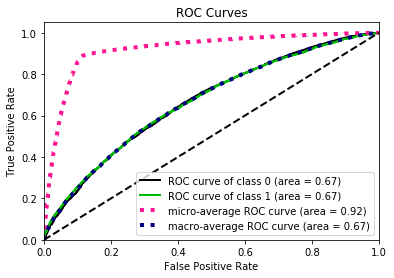

In [194]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
#skplt.metrics.plot_roc(y_test, y_pred)
plt.show()
